In [147]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt



### Data
We have downloaded MSFT stock data of 15min intervals using twelve-data API. The data is stored in a CSV file named `msft15min5000.csv`. (contains 5000 rows of most recent data)

```python
from twelvedata import TDClient

td = TDClient(apikey="YOUR_API_KEY")
ts = td.time_series(symbol='MSFT', interval="15min", outputsize=5000)
df = ts.with_macd().with_macd(fast_period=10).with_stoch().as_pandas()
print(df.head())
df.to_csv('msft15min5000.csv')
```

In [133]:
df = pd.read_csv('msft15min5000.csv')


In [134]:
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

### EDA


C:\Users\deban\AppData\Local\Temp\ipykernel_13012\2731951300.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['MA1'] = moving_average(df['open'], 100)
C:\Users\deban\AppData\Local\Temp\ipykernel_13012\2731951300.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['MA2'] = moving_average(df['open'], 250)


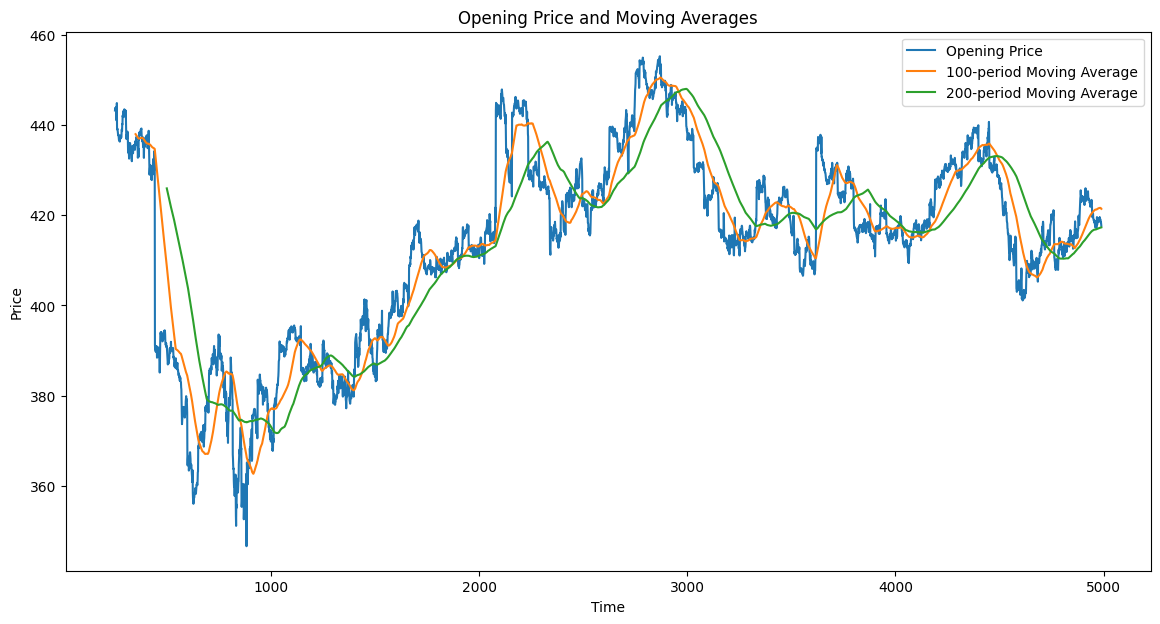

In [153]:
# plot the the opening price and moving average of 20 and 50
df['MA1'] = moving_average(df['open'], 100)
df['MA2'] = moving_average(df['open'], 250)
# plot the the opening price and moving average of 100 and 200
plt.figure(figsize=(14, 7))
plt.plot(df['open'], label='Opening Price')
plt.plot(df['MA1'], label='100-period Moving Average')
plt.plot(df['MA2'], label='200-period Moving Average')
plt.legend()
plt.title('Opening Price and Moving Averages')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

df.drop(['MA1', 'MA2'], axis=1, inplace=True)

### Adding Lagged Features and moving Averages to the Data

In [ ]:
for i in [1, 2, 3, 4, 5,6,7,8,9,10, 15, 20, 30, 50, 100, 150, 200, 250]:
    for col in ['open','high','low','close','volume','macd1','macd_signal1','macd_hist1','macd2','macd_signal2','macd_hist2','slow_k','slow_d']:
        df[f'{col}_{i}'] = df[col].shift(i)

# we also add columns for the moving averages for last n days, n = 10, 20, 30, 50, 100, 150, 200, 250
for i in [10, 20, 30, 50, 100, 150, 200, 250]:
    df[f'close_ma_{i}'] = moving_average(df['close'], i)
    df[f'open_ma_{i}'] = moving_average(df['open'], i)
    df[f'low_ma_{i}'] = moving_average(df['low'], i)
    df[f'high_ma_{i}'] = moving_average(df['high'], i)
    df[f'volume_ma_{i}'] = moving_average(df['volume'], i)

df['label1'] = df['open'].shift(-1)
for i in range(2, 11):
    df[f'label{i}'] = df['open'].shift(-i) # later we will use this to train total 10 models
df = df.dropna()

In [136]:
print(df.columns)


Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'macd1',
       'macd_signal1', 'macd_hist1', 'macd2',
       ...
       'label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'label7',
       'label8', 'label9', 'label10'],
      dtype='object', length=298)


### Train Test Split

In [137]:
# convert datetime to timestamp
df['datetime'] = pd.to_datetime(df['datetime'])

split_at_row = 400

# split at 'split_at_row' row
test = df.iloc[:split_at_row]
train = df.iloc[split_at_row:]

remove_cols = [f'label{i}' for i in range(1, 11)] + ['datetime']

X_train = train.drop(columns=remove_cols)
y_train = train['label1']
X_test = test.drop(columns=remove_cols)
y_test = test['label1']

In [138]:
print(X_train.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'macd1', 'macd_signal1',
       'macd_hist1', 'macd2', 'macd_signal2',
       ...
       'close_ma_200', 'open_ma_200', 'low_ma_200', 'high_ma_200',
       'volume_ma_200', 'close_ma_250', 'open_ma_250', 'low_ma_250',
       'high_ma_250', 'volume_ma_250'],
      dtype='object', length=287)


### Training and prediction


In [139]:
reg = XGBRegressor(n_estimators=5000, learning_rate=0.01)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

### Results

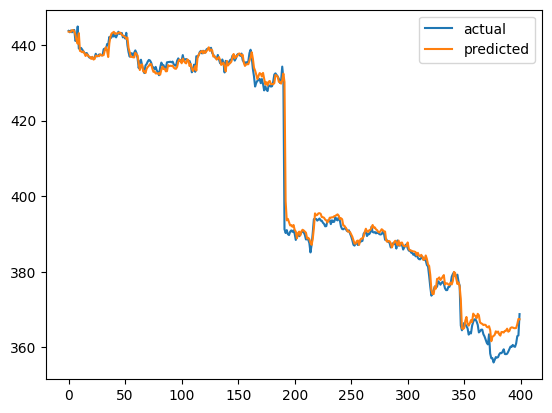

In [140]:
# plot predictions vs actual
import matplotlib.pyplot as plt
plt.plot(y_test.values, label='actual')
plt.plot(y_pred, label='predicted')
plt.legend()
plt.show()


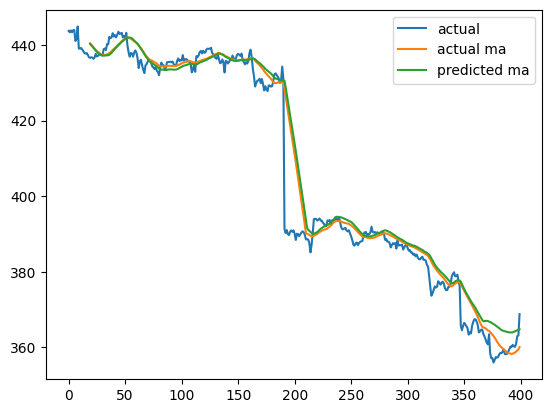

In [141]:
# we also plot moving average of the predictions vs actual
window_size = 20 # i.e. 5 hr (15 min intervals)
y_test_ma = moving_average(pd.Series(y_test.values), window_size)
y_pred_ma = moving_average(pd.Series(y_pred), window_size)
# plot ma predictions vs actual and actual y_test 
plt.plot(y_test.values, label='actual')
plt.plot(y_test_ma.values, label='actual ma')
plt.plot(y_pred_ma.values, label='predicted ma')

plt.legend()
plt.show()

### Real-life Scenario : Predicting 1-10 timestamps ahead

In [142]:
# Now we try to emulate a real life scenario.
# we will train total of 10 models, same training data, but will predict 10 different timeframes.
# ith model will predict i*15 min timeframe. (i = 1,...,10)

#models
models = []
for i in range(1, 11):
    print(f"Training {i}th model")
    reg = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.01, tree_method='hist', device='cuda')
    # X_train remains same, but y_train will be different
    y_train = train[f'label{i}']
    reg.fit(X_train, y_train)
    models.append(reg)

Training 1th model
Training 2th model
Training 3th model
Training 4th model
Training 5th model
Training 6th model
Training 7th model
Training 8th model
Training 9th model
Training 10th model


Visualize any one row's prediction results

In [143]:
# take any one row from test set and predict 10 different labels
import random
row = X_test.iloc[random.randint(0, len(X_test)-1)]
print("Testing row no: ", row.name)
# print(row)
preds = []
# predict 10 different labels
for i in range(10):
    preds.append(models[i].predict(row.values.reshape(1, -1))[0])
actuals = []
# get actuals for the same row
for i in range(10):
    actuals.append(test.iloc[0][f'label{i+1}'])


Testing row no:  578


c:\Python312\Lib\site-packages\xgboost\core.py:729: UserWarning: [13:05:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


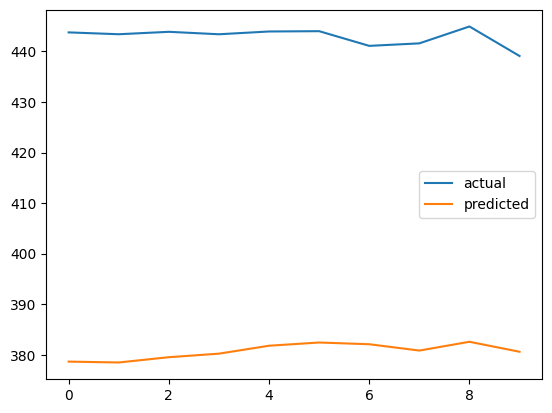

In [144]:
# plot predictions vs actuals
plt.plot(actuals, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()

All rows' prediction results for all 10 models

Testing 1th model


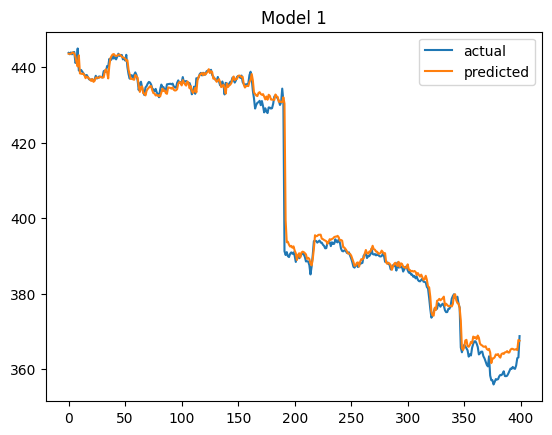

Testing 2th model


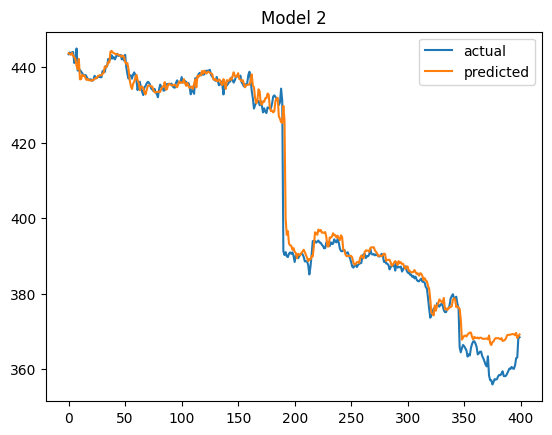

Testing 3th model


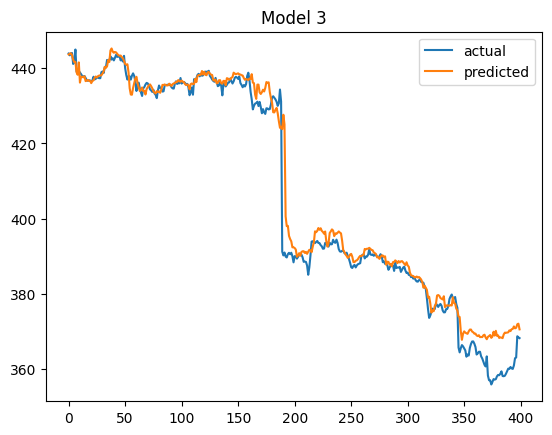

Testing 4th model


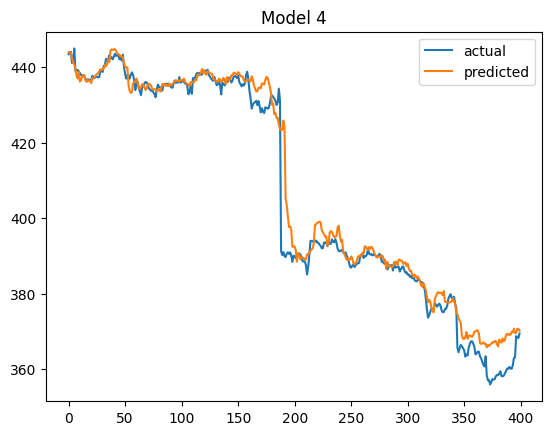

Testing 5th model


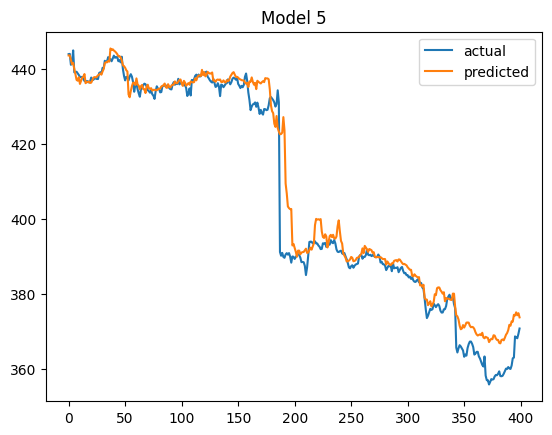

Testing 6th model


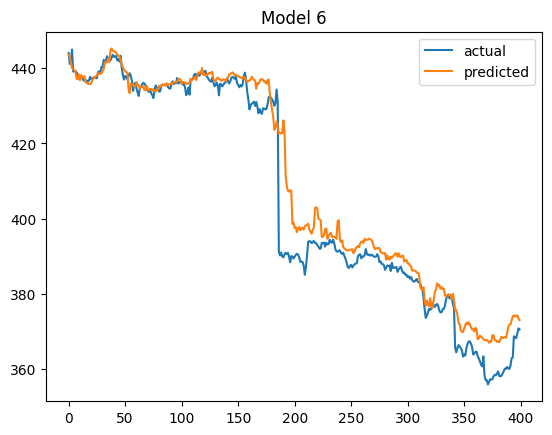

Testing 7th model


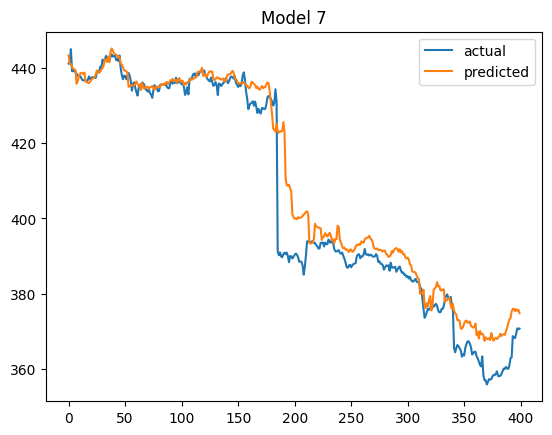

Testing 8th model


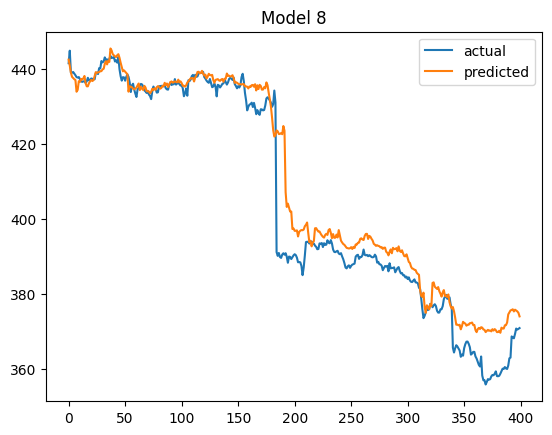

Testing 9th model


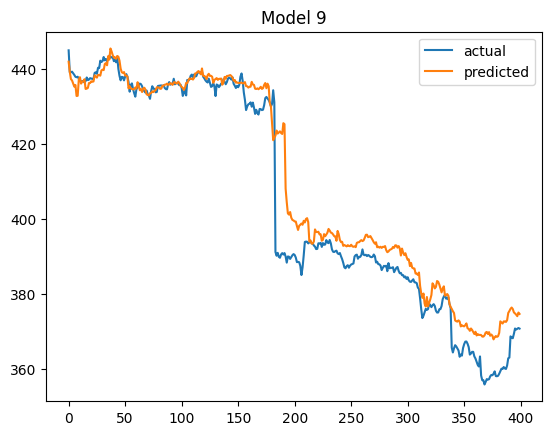

Testing 10th model


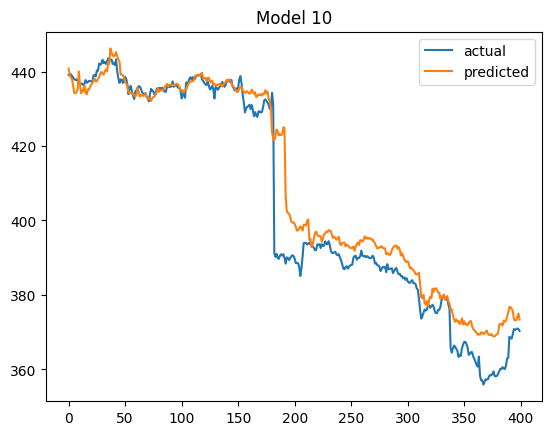

In [145]:
# For each model, predict on the test set and plot the predictions vs actuals
for i in range(10):
    print(f"Testing {i+1}th model")
    y_pred = models[i].predict(X_test)
    y_test = test[f'label{i+1}']
    # plot predictions vs actuals
    plt.plot(y_test.values, label='actual')
    plt.plot(y_pred, label='predicted')
    plt.legend()
    plt.title(f"Model {i+1}")
    plt.show()

### Realistic Trading Strategy
We see huge differences in prediction vs actual values. But the patterns are similar. So we device a trading strategy based on this fact.

Total profit/loss:  887.3716700000004
Mean profit/loss:  2.218429175000001
Avg profit:  4.104059325842698
Avg loss:  -1.5670087969924786


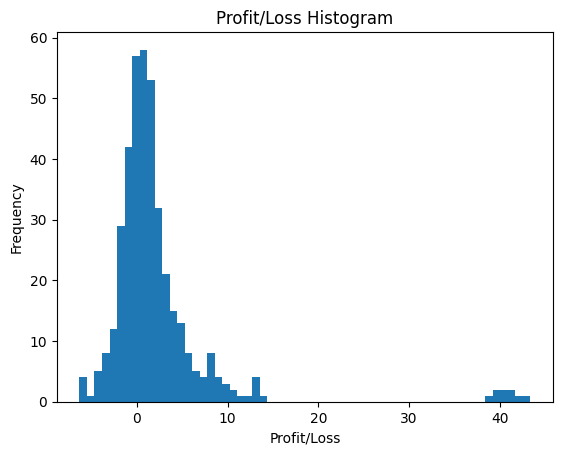

In [154]:
# now we emulate a trading strategy. 

# STRATEGY: For each test row, we predict next 10 timestamps (i.e. total 2.5 hr ahead).
# Now, we find the timestamps for highest and lowest predicted values.
# We will buy at the lowest predicted timestamp and sell at the highest predicted timestamp.


# for each datapoint in the test set, we predict the 10 labels, those are the 10 different timeframes from now on. So we will have 10 different predictions for each row in the test set.
# for each rows 10 label predictions, we find the highest and lowest predicted value's index.
# now use the indices to get the actual values of labels from the test set and take the difference between the two values.
# we now use the actual differences to calculate the profit/loss.
test_rows = 400
act_df = test.copy().iloc[:test_rows]
for i in range(10):
    # print(f"Testing {i+1}th model")
    model = models[i]
    y_pred = model.predict(X_test.iloc[:test_rows])
    act_df[f'pred_{i+1}'] = y_pred
# Now we have 10 different predictions for each row in the test set, find the highest and lowest predicted value's column name (like pred_1, pred_2, etc), then take number at the end of the column name (as index) (for example, if pred_1 is highest, then take 1 as index)
act_df['max_pred_idx'] = act_df[[f'pred_{i+1}' for i in range(10)]].idxmax(axis=1)
act_df['min_pred_idx'] = act_df[[f'pred_{i+1}' for i in range(10)]].idxmin(axis=1)
# add 1 to both max_pred_idx and min_pred_idx to get the actual label number (label1, label2, etc)
act_df['max_pred_idx'] = act_df['max_pred_idx'].apply(lambda x: int(x.split('_')[1]))
act_df['min_pred_idx'] = act_df['min_pred_idx'].apply(lambda x: int(x.split('_')[1]))
# act_df.head()
# now do label{max_pred_idx} - label{min_pred_idx}; we already have the labels in act_df
act_df['profit'] = act_df.apply(lambda x: x[f'label{x.max_pred_idx}'] - x[f'label{x.min_pred_idx}'], axis=1)
print("Total profit/loss: ", act_df['profit'].sum())
print("Mean profit/loss: ", act_df['profit'].mean())
print("Avg profit: ", act_df[act_df['profit'] > 0]['profit'].mean())
print("Avg loss: ", act_df[act_df['profit'] < 0]['profit'].mean())

# plot histogram of profit/loss
plt.hist(act_df['profit'], bins=60) 
plt.title('Profit/Loss Histogram')
plt.xlabel('Profit/Loss')
plt.ylabel('Frequency')
plt.show()

    